<a href="https://colab.research.google.com/github/DeanHazineh/DFlat/blob/main/examples/metalens_neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DFlat is built on top of Tensorflow's Keras. If you want to use GPU speedup for all executions, click runtime at the top and enable GPU acceleration. This is recommended to get results ~20-30x faster


# Cloning and Installing the repository


In [ ]:
!git lfs install
!git clone https://github.com/DeanHazineh/DFlat

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
fatal: destination path 'DFlat' already exists and is not an empty directory.


In [ ]:
%cd DFlat

/content/DFlat


In [ ]:
!python setup.py develop

running develop
running egg_info
writing DFlat.egg-info/PKG-INFO
writing dependency_links to DFlat.egg-info/dependency_links.txt
writing top-level names to DFlat.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'DFlat.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/DFlat.egg-link (link to .)
DFlat 1.0.1 is already the active version in easy-install.pth

Installed /content/DFlat
Processing dependencies for DFlat==1.0.1
Finished processing dependencies for DFlat==1.0.1


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Create a general optimization pipeline using the psf layer and the rcwa optical model 

A general class can be reused for different settings (e.g. neural models) or loss functions as defined in the next section! This is why we structure the software flow like this!


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

import dflat.optimization_helpers as df_optimizer
import dflat.fourier_layer as df_fourier
import dflat.neural_optical_layer as df_neural
import dflat.physical_optical_layer as df_physical
import dflat.data_structure as df_struct
import dflat.tools as df_tools



It is convenient for inverse design to build off of DFlats df_optimizer.Pipeline_Object 

Inhereriting this class as the parent automatically manages checkpoint saving and loading for the custom keras model.



Most of the lines are used to define the visualizeTrainingCheckpoint. This is a plotting functions that will be called during save checkpoints (intermediary epochs) to monitor the process! Defining this function (overides parent class) is optional! If not included, no visualization plots will be made but the code will still run.

In the collab, these plots wont actually save since no google drive or harddrive is mounted but that is okay! we can always view plots manually at the end by tweaking the code and calling the function with plt.show()




In [ ]:

class pipeline_Metalens_MLP(df_optimizer.Pipeline_Object):

    def __init__(self, propagation_parameters, point_source_locs, savepath, saveAtEpochs=None):
        super(pipeline_Metalens_MLP, self).__init__(savepath, saveAtEpochs)

        self.propagation_parameters = propagation_parameters
        self.point_source_locs = point_source_locs

        # define computational layers
        mlp_model = "MLP_Nanocylinders_Dense64_U180_H600"
        self.mlp_latent_layer = df_neural.MLP_Latent_Layer(mlp_model)
        self.psf_layer = df_fourier.PSF_Layer_Mono(propagation_parameters)  # broadband psf layer can be used instead

        # Make uniform state latent tensor as initial variable for metasurface with helper function
        gridShape = propagation_parameters["grid_shape"]
        latent_tensor_variable = self.mlp_latent_layer.initialize_input_tensor("uniform", gridShape, tf.float64)
        self.latent_tensor_variable = tf.Variable(
            latent_tensor_variable, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor"
        )

        # # The lens can be initialized in another state like a focusing lens
        # focus_trans, focus_phase, _, _ = df_fourier.focus_lens_init(
        #     propagation_parameters, [532e-9], [0.5], [{"x": 0, "y": 0}]
        # )
        # _, norm_shape = df_neural.optical_response_to_param(
        #     [focus_trans], [focus_phase], [532e-9], "Nanocylinders_U180nm_H600nm", reshape=True
        # )
        # latent_tensor = df_tools.param_to_latent(norm_shape[0])
        # latent_tensor_variable = tf.Variable(
        #     latent_tensor, trainable=True, dtype=tf.float64, name="metasurface_latent_tensor"
        # )
        return

    def __call__(self):
        wavelength_m = self.propagation_parameters["wavelength_m"]
        out = self.mlp_latent_layer(self.latent_tensor_variable, [wavelength_m])
        psf_intensity, psf_phase = self.psf_layer(out, self.point_source_locs)

        self.last_lens = out
        self.last_psf = psf_intensity
        return psf_intensity

    def visualizeTrainingCheckpoint(self, saveto, showPlot=False):
        # This overrides the baseclass visualization call function, called during checkpoints
        savefigpath = self.savepath + "/trainingOutput/"
        radial_flag = self.propagation_parameters["radial_symmetry"]

        xl, yl = df_fourier.getCoordinates_vector(
            self.propagation_parameters["ms_samplesM"],
            self.propagation_parameters["ms_dx_m"],
            radial_flag,
            tf.float32,
        )
        xd, yd = df_fourier.getCoordinates_vector(
            self.propagation_parameters["sensor_pixel_number"],
            self.propagation_parameters["sensor_pixel_size_m"],
            False,
            tf.float32,
        )

        # Plot the Lens
        latent_tensor_state = self.get_variable_by_name("metasurface_latent_tensor")[0]
        norm_shape = df_tools.latent_to_param(latent_tensor_state)
        trans = self.last_lens[0]
        phase = self.last_lens[1]

        fig = plt.figure(figsize=(40, 10))
        axList = df_tools.addAxis(fig, 1, 3)
        if radial_flag:
            axList[0].plot(xl[0, :] * 1e3, norm_shape[0, 0, :])
            df_tools.formatPlots(
                fig,
                axList[0],
                None,
                xlabel="lens x (mm)",
                ylabel="normalized radius len",
                setAspect="auto",
            )

            axList[1].plot(xl[0, :] * 1e3, phase[0, 0, 0, :], "bx-")
            axList[1].plot(xl[0, :] * 1e3, trans[0, 0, 0, :], "kx-")
            df_tools.formatPlots(
                fig,
                axList[1],
                None,
                xlabel="lens x (mm)",
                ylabel="Trans and Phase",
                setAspect="auto",
            )
        else:
            im0 = axList[0].imshow(
                norm_shape[0, :, :], extent=(np.min(xl)*1e3, np.max(xl)*1e3, np.max(yl)*1e3, np.min(yl)*1e3), vmin=0, vmax=1
            )
            df_tools.formatPlots(
                fig,
                axList[0],
                im0,
                xlabel="lens x (mm)",
                ylabel="lens y (nm)",
                title="Learned Metasurface",
                setAspect="equal",
                addcolorbar=True,
                cbartitle="Normalized Radius (nm)",
            )

            im1 = axList[1].imshow(
                phase[0, 0, :, :], extent=(np.min(xl)*1e3, np.max(xl)*1e3, np.max(yl)*1e3, np.min(yl)*1e3), vmin=-np.pi, vmax=np.pi
            )
            df_tools.formatPlots(
                fig,
                axList[1],
                im1,
                xlabel="lens x (mm)",
                ylabel="lens y (mm)",
                title="Learned Phase",
                setAspect="equal",
                addcolorbar=True,
                cbartitle="Phase (radians)",
            )

        im = axList[2].imshow(
            self.last_psf[0, 0, 0, :, :],
            extent=(
                np.min(xd) * 1e3,
                np.max(xd) * 1e3,
                np.max(yd) * 1e3,
                np.min(yd) * 1e3,
            ),
        )
        df_tools.formatPlots(
            fig,
            axList[2],
            im,
            xlabel="det x (mm)",
            ylabel="det y (mm)",
            title="PSF Intensity",
            addcolorbar=True,
            setAspect="equal",
        )

        if not showPlot:
          plt.savefig(savefigpath + "png_images/" + saveto + "epoch_checkpointFig.png")
          plt.savefig(savefigpath + "pdf_images/" + saveto + "epoch_checkpointFig.pdf")
          plt.close()
        return


# Define Simulation Settings and run the optimization

In [ ]:

def optimize_metalens_mlp(radial_symmetry, num_epochs=30, try_gpu=True):

    # Define propagation parameters for psf calculation
    propagation_parameters = df_struct.prop_params(
        {
            "wavelength_m": 532e-9,
            "ms_length_m": {"x": 1.0e-3, "y": 1.0e-3},
            "ms_dx_m": {"x": 10 * 180e-9, "y": 10 * 180e-9},
            "radius_m": 1.0e-3 / 2.01,
            "sensor_distance_m": 10e-3,
            "initial_sensor_dx_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_size_m": {"x": 1e-6, "y": 1e-6},
            "sensor_pixel_number": {"x": 501, "y": 501},
            "radial_symmetry": radial_symmetry,
            "diffractionEngine": "fresnel_fourier",
            "accurate_measurement": True,  # Flag ensures output grid is exact but is expensive
        },
        verbose=False,
    )

    # Point_source locs we want to compute the psf for (distance to lens)
    point_source_locs = np.array([[0.0, 0.0, 1e6]])  # on-axis ps at 1e6 m away (~infinity)

    # Call the pipeline
    savepath = "examples/output/metalens_example_radial" + str(radial_symmetry) + "/"
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    pipeline = pipeline_Metalens_MLP(propagation_parameters, point_source_locs, savepath, saveAtEpochs=5)
    pipeline.customLoad()  # restore previous training checkpoint if it exists

    # Define custom Loss function (Should always have pipeline_output as the function input)
    sensor_pixel_number = propagation_parameters["sensor_pixel_number"]
    cidx_y = sensor_pixel_number["y"] // 2
    cidx_x = sensor_pixel_number["x"] // 2

    def loss_fn(pipeline_output):
        return -pipeline_output[0, 0, 0, cidx_y, cidx_x]

    learning_rate = 1e-2
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    df_optimizer.run_pipeline_optimization(
        pipeline, optimizer, num_epochs=num_epochs, loss_fn=tf.function(loss_fn), allow_gpu=try_gpu
    )

    # Explicitly call and show the plot from visualizeCheckpoint
    # Normally this is saved in a folder and you wouldn't call it manually
    pipeline.visualizeTrainingCheckpoint(saveto="", showPlot=True)
    plt.show()

    return

Run with radial symmetry Flag. Only a radial vector for the metasurface is trained and fields are propagated using an efficient, approximate Hankel transform

Checking for model checkpoint at: dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 

Checking for model checkpoint at: examples/output/metalens_example_radialTrue/
Training Log | (Step, time, loss):  0 3.5020911693573 -1.8583613550108367e-06
Training Log | (Step, time, loss):  1 3.3320250511169434 -0.00010834932509371442
Training Log | (Step, time, loss):  2 3.2910189628601074 -0.0003547750483337107
Training Log | (Step, time, loss):  3 3.338034152984619 -0.0007267984363509998
Training Log | (Step, time, loss):  4 3.318425178527832 -0.0012268835441528799
Training Log | (Step, time, loss):  5 3.336317777633667 -0.0018273378890107117
Log Training at step: 5

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  6 3.3744828701019287 -0.002512525889815452
Training Log | (Step, time, loss):  7 3.324676036834717 -0.003156444061142504
Training Log | (Step, time, loss):  8 3.3338348865509033 -0.003976709627627595
Training Log | (Step, time, loss):  9 3.3488054275512695 -0.004879414297379006
Training Log | (Step, time, loss):  10 3.3593380451202393 -0.005937807697105184
Log Training at step: 10

 Model Saved Succesfully 

Training Log | (Step, time, loss):  11 3.3879830837249756 -0.007114632490902918
Training Log | (Step, time, loss):  12 3.3395872116088867 -0.008403541369438359
Training Log | (Step, time, loss):  13 3.2988994121551514 -0.009776262187973138
Training Log | (Step, time, loss):  14 4.107691049575806 -0.011137108615743373
Training Log | (Step, time, loss):  15 3.3649747371673584 -0.01239636887648061
Log Training at step: 15

 Model Saved Succesfully 

Training Log | (Step, time, loss):  16 3.436964988708496 -0.013493878684814203
Training Log | (Step, 

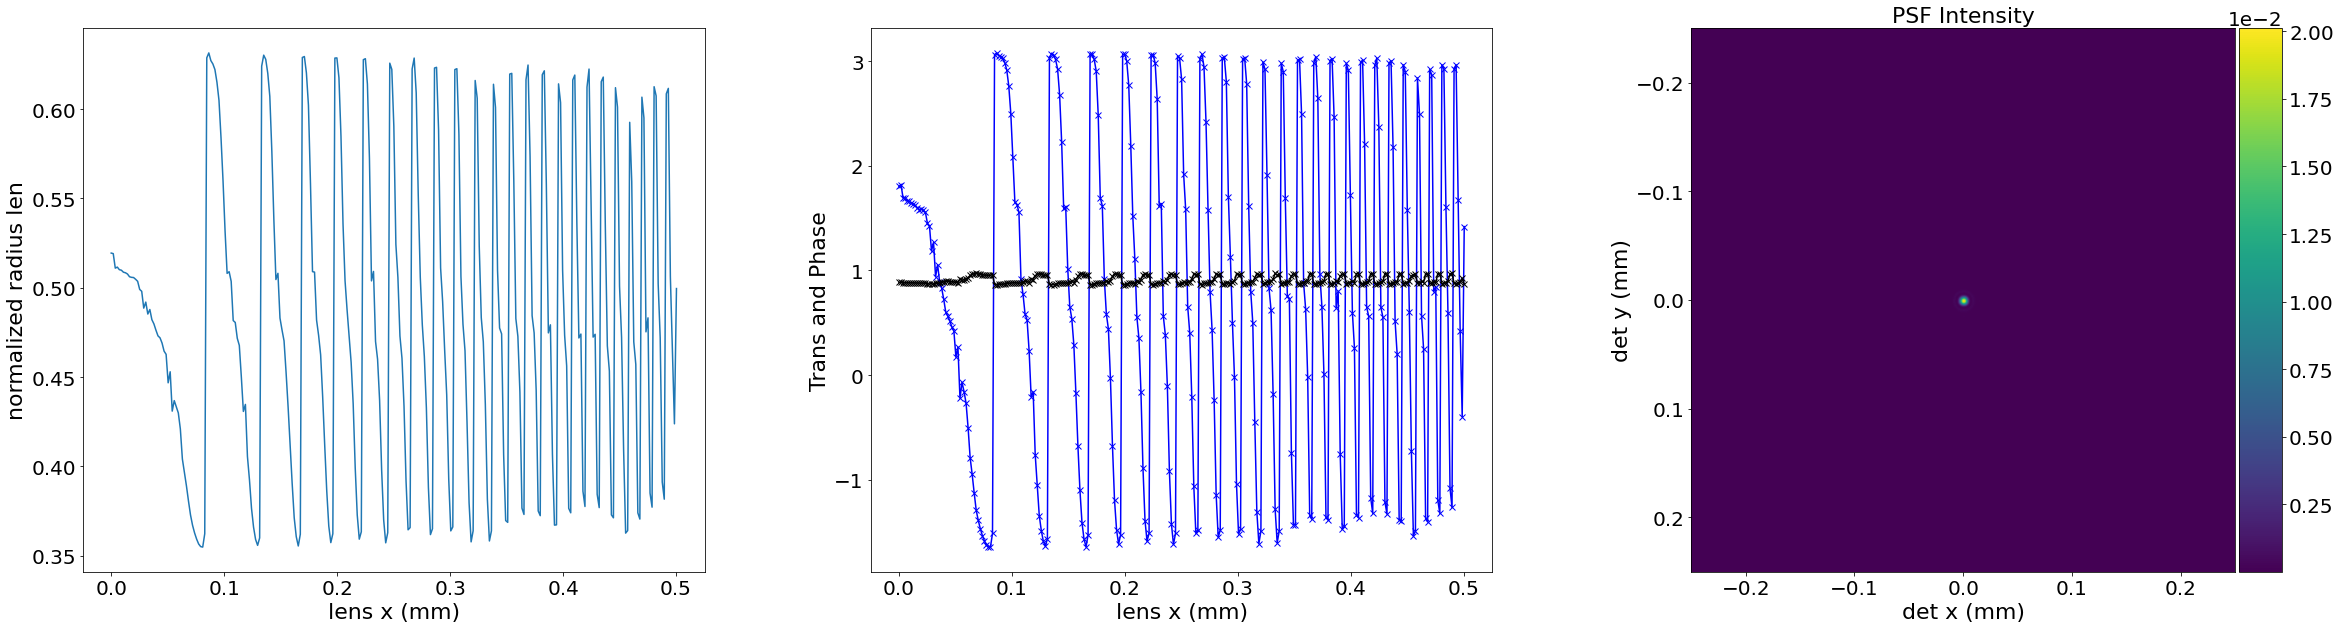

In [ ]:
optimize_metalens_mlp(radial_symmetry=True, num_epochs=30, try_gpu=True)


Now run without radial symmetry Flag. The 2D metasurface will be assembled and 2D fields will be propagated instead. Cool, asymmetric PSFs can in theory be discovered like this but the memory costs are higher!


Checking for model checkpoint at: dflat/neural_optical_layer/core/trained_MLP_models/MLP_Nanocylinders_Dense64_U180_H600/

 Model Checkpoint Loaded 

Checking for model checkpoint at: examples/output/metalens_example_radialFalse/

 Model Checkpoint Loaded 

Training Log | (Step, time, loss):  0 3.563859224319458 -0.0009373118857628504
Training Log | (Step, time, loss):  1 3.089750051498413 -0.0010038576598576203
Training Log | (Step, time, loss):  2 3.059262752532959 -0.001097434895146091
Training Log | (Step, time, loss):  3 3.164724588394165 -0.0012135187298430645
Training Log | (Step, time, loss):  4 3.056107759475708 -0.0013504831406114261
Training Log | (Step, time, loss):  5 3.164947748184204 -0.0015074656451372643
Log Training at step: 5

 Model Saved Succesfully 



/content/DFlat/dflat/optimization_helpers/pipeline_class.py:68: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(self.loss_vector))


Training Log | (Step, time, loss):  6 3.3905372619628906 -0.001685282757002047
Training Log | (Step, time, loss):  7 3.195627450942993 -0.0018862104070141688
Training Log | (Step, time, loss):  8 3.2770042419433594 -0.0021083752359980453
Training Log | (Step, time, loss):  9 3.2169525623321533 -0.0023423124750462103
Training Log | (Step, time, loss):  10 3.106167793273926 -0.0025802674304507603
Log Training at step: 10

 Model Saved Succesfully 

Training Log | (Step, time, loss):  11 3.191004991531372 -0.0028261794445249206
Training Log | (Step, time, loss):  12 3.0379552841186523 -0.003082600409595416
Training Log | (Step, time, loss):  13 3.0806803703308105 -0.0033504752365857574
Training Log | (Step, time, loss):  14 3.1375298500061035 -0.0036144029065603147
Training Log | (Step, time, loss):  15 3.0751430988311768 -0.0038680479534649553
Log Training at step: 15

 Model Saved Succesfully 

Training Log | (Step, time, loss):  16 3.8075191974639893 -0.004179801763926496
Training Log 

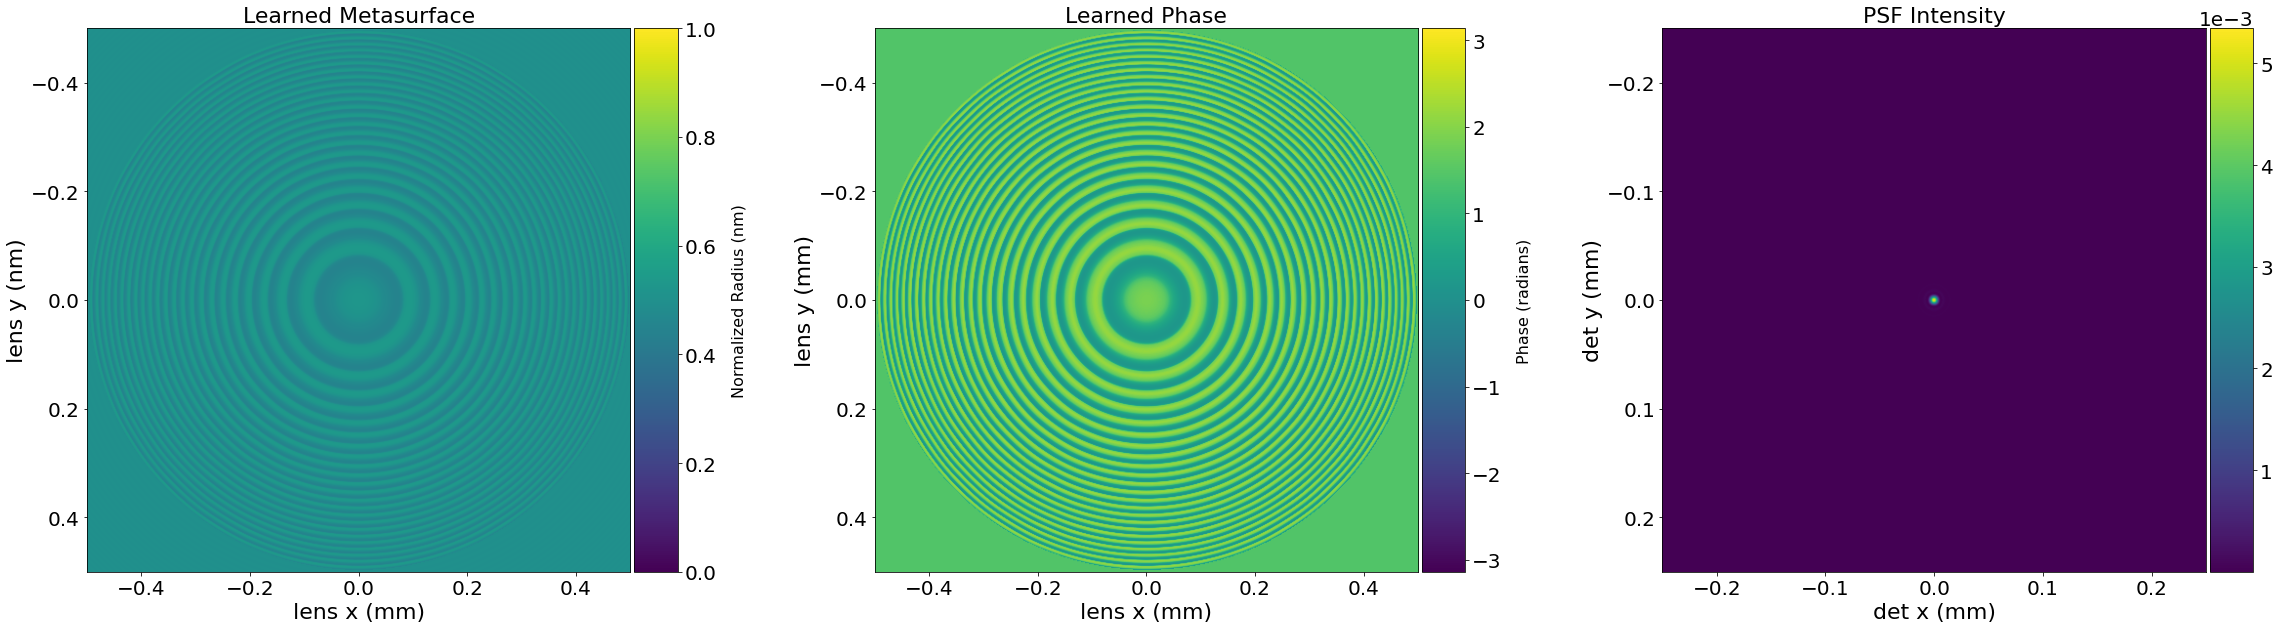

In [ ]:
optimize_metalens_mlp(radial_symmetry=False, num_epochs=20, try_gpu=True)
